Creating Testing Set Data

Code based on: https://towardsdatascience.com/board-game-image-recognition-using-neural-networks-116fc876dafa and https://arxiv.org/pdf/2104.14963v2.pdf

In [ ]:
#blender-renders
!gdown --id 1xt-ySFP6pAiOekM3yZpTRtg8rQOgJUe-
!unzip -q test_renders.zip

Downloading...
From: https://drive.google.com/uc?id=1xt-ySFP6pAiOekM3yZpTRtg8rQOgJUe-
To: /content/test_renders.zip
100% 252M/252M [00:01<00:00, 133MB/s]


In [2]:
import glob
import math
import cv2
import numpy as np
import scipy.spatial as spatial
import scipy.cluster as cluster
from collections import defaultdict
from statistics import mean
from google.colab.patches import cv2_imshow
from numpy.polynomial import polynomial as P
import os
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import typing
import matplotlib.pyplot as plt
import json

In [3]:
def print_points(img, points, c=(255,0,0)):
  for point_list in points:
    for point in point_list:
      p = (round(point[0]), round(point[1]))
      img = cv2.circle(img, p, radius=5, color=c, thickness=-1)
  cv2_imshow(img)

def print_lines(img, lines, color=(0,0,255)):
  for line in lines:
    rho = line[0]
    theta = line[1]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),color,2)
  cv2_imshow(img)

# Read image and do lite image processing
def read_img(file):
    img = cv2.imread(str(file), 1)

    W = 1000
    height, width, depth = img.shape
    imgScale = W / width
    newX, newY = img.shape[1] * imgScale, img.shape[0] * imgScale
    img = cv2.resize(img, (int(newX), int(newY)))
    
    blur = cv2.bilateralFilter(img,9,75,75)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, im_bw) = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)  #| cv2.THRESH_OTSU)
    #im_bw = cv2.bilateralFilter(im_bw,9,75,75)
    
    return img, im_bw

# Canny edge detection
def canny_edge(img, sigma=0.33):
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(img, lower, upper)

    return edges

# Hough line detection
def hough_line(edges, img, min_line_length=100, max_line_gap=30, threshold = 90):
    lines = cv2.HoughLines(edges, 1.5, np.pi / 110, threshold, min_line_length, max_line_gap)
    
    lines = np.reshape(lines, (-1, 2))
    return lines

def merge_lines(lines, img, rho_thresh=14):
    strong_lines = np.zeros_like(lines)
    n2 = 0

    for n1 in range (len(lines)):
      line = lines[n1]

      if line[0] < 0:
        line[0] *= -1
        line[1] -= np.pi

      if not ((line[1] >= (4/9*np.pi) and line[1] <= (5/9*np.pi)) or (line[1] >= (-np.pi/9) and line[1] <= (np.pi/9))):
        continue

      rho = line[0]
      theta = line[1]
      if n1 == 0:
        strong_lines[n2] = lines[n1]
        n2 = n2 + 1
        continue

      closeness_rho = np.isclose(rho,strong_lines[0:n2,0],atol = rho_thresh)
      similar_rho = np.any(closeness_rho)

      if not similar_rho: 
        strong_lines[n2] = line
        n2 += 1

    strong_lines = strong_lines[0:n2]
    
    return strong_lines


# Separate line into horizontal and vertical
def h_v_lines(lines):
    h_lines, v_lines = [], []
    for rho, theta in lines:
        if theta < np.pi / 4 or theta > np.pi - np.pi / 4:
            v_lines.append([rho, theta])
        else:
            h_lines.append([rho, theta])
    return h_lines, v_lines

# Find the intersections of the lines
def line_intersections(h_lines, v_lines):
    points = []
    for r_h, t_h in h_lines:
        for r_v, t_v in v_lines:
            a = np.array([[np.cos(t_h), np.sin(t_h)], [np.cos(t_v), np.sin(t_v)]])
            b = np.array([r_h, r_v])
            inter_point = np.linalg.solve(a, b)
            points.append(inter_point)
    return np.array(points)


# Hierarchical cluster (by euclidean distance) intersection points
def cluster_points(points, thresh=15):
    dists = spatial.distance.pdist(points)
    single_linkage = cluster.hierarchy.single(dists)
    flat_clusters = cluster.hierarchy.fcluster(single_linkage, thresh, 'distance')
    cluster_dict = defaultdict(list)
    for i in range(len(flat_clusters)):
        cluster_dict[flat_clusters[i]].append(points[i])
    cluster_values = cluster_dict.values()
    clusters = map(lambda arr: (np.mean(np.array(arr)[:, 0]), np.mean(np.array(arr)[:, 1])), cluster_values)
    return sorted(list(clusters), key=lambda k: [k[1], k[0]])


# Average the y value in each row and augment original point
def augment_points(points, img):
    discard = False
    points_shape = list(np.shape(points))
    augmented_points = []

    if int(points_shape[0] / 11) != 11: discard = True

    for row in range(int(points_shape[0] / 11)):
        start = row * 11
        end = (row * 11) + 10
        rw_points = points[start:end + 1]
        rw_y = []
        rw_x = []
        for point in rw_points:
            x, y = point
            rw_y.append(y)
            rw_x.append(x)
        y_mean = mean(rw_y)
        if len(rw_x) != 11: discard = True
        for i in range(len(rw_x)):
            point = (rw_x[i], y_mean)
            augmented_points.append(point)
    augmented_points = sorted(augmented_points, key=lambda k: [k[1], k[0]])
    return augmented_points, discard

def get_coord_distance(p1, p2):
    coordinate_distance = math.sqrt( ((int(p1[0])-int(p2[0]))**2)+((int(p1[1])-int(p2[1]))**2) )
    return coordinate_distance

def write_crop_images_predict(img, points, avg_base_len):
    num_list = []
    shape = list(np.shape(points))
    start_point = shape[0] - 14

    if int(shape[0] / 11) >= 8:
        range_num = 8
    else:
        range_num = int((shape[0] / 11) - 2)

    for row in range(range_num):
        start = start_point - (row * 11)
        end = (start_point - 8) - (row * 11)
        num_list.append(range(start, end, -1))  

    for i in range(len(num_list)):
        row = num_list[i]
        for j in range(len(row)):
            s = row[j]
            base_len = get_coord_distance(points[s], points[s + 1])


    board = [None] * 64
    pieceidx = 0
    for i in range(len(num_list)):
        row = num_list[i]
        for j in range(len(row)):
            s = row[j]
            
            x_dist = avg_base_len
            
            bot_left = points[s]
            start_x, start_y = int(bot_left[0]), int(bot_left[1] - (x_dist * 2))
            end_x, end_y = int(start_x + x_dist), int(start_y + 2*x_dist)
            if start_y < 0:
                start_y = 0
            if start_x < 0:
                start_x = 0

            cropped = img[start_y: end_y, start_x: end_x]
            dims = (46, 92)
            cropped = cv2.resize(cropped, dims)
            cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
            board[pieceidx] = cropped
            pieceidx += 1

    return board

def find_base_len(img, points):
    num_list = []
    shape = list(np.shape(points))
    start_point = shape[0] - 14

    if int(shape[0] / 11) >= 8:
        range_num = 8
    else:
        range_num = int((shape[0] / 11) - 2)

    for row in range(range_num):
        start = start_point - (row * 11)
        end = (start_point - 8) - (row * 11)
        num_list.append(range(start, end, -1))  


    avg_base_len = 0

    for i in range(len(num_list)):
        row = num_list[i]
        for j in range(len(row)):
            s = row[j]
            bot_left, bot_right = points[s], points[s + 1]
            start_x, end_x = int(bot_left[0]), int(bot_right[0])
            
            base_len = abs(start_x - end_x)
            avg_base_len += base_len


    avg_base_len = avg_base_len / 64

    return round(avg_base_len)

def resize_image(img: np.ndarray) -> typing.Tuple[np.ndarray, float]:
    """Resize an image for use in the corner detection pipeline, maintaining the aspect ratio.
    Args:
        cfg (CN): the configuration object
        img (np.ndarray): the input image
    Returns:
        typing.Tuple[np.ndarray, float]: the resized image along with the scale of this new image
    """
    RESIZE_IMAGE_WIDTH = 1200
    h, w, _ = img.shape
    if w == RESIZE_IMAGE_WIDTH:
        return img, 1
    scale = RESIZE_IMAGE_WIDTH / w
    dims = (RESIZE_IMAGE_WIDTH, int(h * scale))

    img = cv2.resize(img, dims)
    return img, scale


def _detect_edges(gray: np.ndarray, LOW_THRESHOLD = 90, HIGH_THRESHOLD = 400, APERTURE = 3) -> np.ndarray:
    if gray.dtype != np.uint8:
        gray = gray / gray.max() * 255
        gray = gray.astype(np.uint8)
    edges = cv2.Canny(gray,
                      LOW_THRESHOLD,
                      HIGH_THRESHOLD,
                      APERTURE)
    return edges


def _detect_lines(edges: np.ndarray) -> np.ndarray:
    THRESHOLD = 150
    DIAGONAL_LINE_ELIMINATION = True
    DIAGONAL_LINE_ELIMINATION_THRESHOLD_DEGREES = 30
    # array of [rho, theta]
    lines = cv2.HoughLines(edges, 1, np.pi/360, THRESHOLD)
    lines = lines.squeeze(axis=-2)
    lines = _fix_negative_rho_in_hesse_normal_form(lines)

    if DIAGONAL_LINE_ELIMINATION:
        threshold = np.deg2rad(
            DIAGONAL_LINE_ELIMINATION_THRESHOLD_DEGREES)
        vmask = np.abs(lines[:, 1]) < threshold
        hmask = np.abs(lines[:, 1] - np.pi / 2) < threshold
        mask = vmask | hmask
        lines = lines[mask]
    return lines


def _fix_negative_rho_in_hesse_normal_form(lines: np.ndarray) -> np.ndarray:
    lines = lines.copy()
    neg_rho_mask = lines[..., 0] < 0
    lines[neg_rho_mask, 0] = - \
        lines[neg_rho_mask, 0]
    lines[neg_rho_mask, 1] =  \
        lines[neg_rho_mask, 1] - np.pi
    return lines


def _absolute_angle_difference(x, y):
    diff = np.mod(np.abs(x - y), 2*np.pi)
    return np.min(np.stack([diff, np.pi - diff], axis=-1), axis=-1)


def _sort_lines(lines: np.ndarray) -> np.ndarray:
    if lines.ndim == 0 or lines.shape[-2] == 0:
        return lines
    rhos = lines[..., 0]
    sorted_indices = np.argsort(rhos)
    return lines[sorted_indices]


def _cluster_horizontal_and_vertical_lines(lines: np.ndarray):
    lines = _sort_lines(lines)
    thetas = lines[..., 1].reshape(-1, 1)
    distance_matrix = pairwise_distances(
        thetas, thetas, metric=_absolute_angle_difference)
    agg = AgglomerativeClustering(n_clusters=2, affinity="precomputed",
                                  linkage="average")
    clusters = agg.fit_predict(distance_matrix)

    angle_with_y_axis = _absolute_angle_difference(thetas, 0.)
    if angle_with_y_axis[clusters == 0].mean() > angle_with_y_axis[clusters == 1].mean():
        hcluster, vcluster = 0, 1
    else:
        hcluster, vcluster = 1, 0

    horizontal_lines = lines[clusters == hcluster]
    vertical_lines = lines[clusters == vcluster]

    return horizontal_lines, vertical_lines


def _eliminate_similar_lines(lines: np.ndarray, perpendicular_lines: np.ndarray) -> np.ndarray:
    perp_rho, perp_theta = perpendicular_lines.mean(axis=0)
    rho, theta = np.moveaxis(lines, -1, 0)
    intersection_points = get_intersection_point(
        rho, theta, perp_rho, perp_theta)
    intersection_points = np.stack(intersection_points, axis=-1)

    clustering = DBSCAN(eps=12, min_samples=1).fit(intersection_points)

    filtered_lines = []
    for c in range(clustering.labels_.max() + 1):
        lines_in_cluster = lines[clustering.labels_ == c]
        rho = lines_in_cluster[..., 0]
        median = np.argsort(rho)[len(rho)//2]
        filtered_lines.append(lines_in_cluster[median])
    return np.stack(filtered_lines)


def get_intersection_point(rho1: np.ndarray, theta1: np.ndarray, rho2: np.ndarray, theta2: np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray]:
    """Obtain the intersection point of two lines in Hough space.
    This method can be batched
    Args:
        rho1 (np.ndarray): first line's rho
        theta1 (np.ndarray): first line's theta
        rho2 (np.ndarray): second lines's rho
        theta2 (np.ndarray): second line's theta
    Returns:
        typing.Tuple[np.ndarray, np.ndarray]: the x and y coordinates of the intersection point(s)
    """
    # rho1 = x cos(theta1) + y sin(theta1)
    # rho2 = x cos(theta2) + y sin(theta2)
    cos_t1 = np.cos(theta1)
    cos_t2 = np.cos(theta2)
    sin_t1 = np.sin(theta1)
    sin_t2 = np.sin(theta2)
    x = (sin_t1 * rho2 - sin_t2 * rho1) / (cos_t2 * sin_t1 - cos_t1 * sin_t2)
    y = (cos_t1 * rho2 - cos_t2 * rho1) / (sin_t2 * cos_t1 - sin_t1 * cos_t2)
    return x, y


def _choose_from_range(upper_bound: int, n: int = 2):
    return np.sort(np.random.choice(np.arange(upper_bound), (n,), replace=False), axis=-1)


def _get_intersection_points(horizontal_lines: np.ndarray, vertical_lines: np.ndarray) -> np.ndarray:
    rho1, theta1 = np.moveaxis(horizontal_lines, -1, 0)
    rho2, theta2 = np.moveaxis(vertical_lines, -1, 0)

    rho1, rho2 = np.meshgrid(rho1, rho2, indexing="ij")
    theta1, theta2 = np.meshgrid(theta1, theta2, indexing="ij")
    intersection_points = get_intersection_point(rho1, theta1, rho2, theta2)
    intersection_points = np.stack(intersection_points, axis=-1)
    return intersection_points


def compute_transformation_matrix(src_points: np.ndarray, dst_points: np.ndarray) -> np.ndarray:
    """Compute the transformation matrix based on source and destination points.
    Args:
        src_points (np.ndarray): the source points (shape: [..., 2])
        dst_points (np.ndarray): the source points (shape: [..., 2])
    Returns:
        np.ndarray: the transformation matrix
    """
    transformation_matrix, _ = cv2.findHomography(src_points.reshape(-1, 2),
                                                  dst_points.reshape(-1, 2))
    return transformation_matrix


def _compute_homography(intersection_points: np.ndarray, row1: int, row2: int, col1: int, col2: int):
    p1 = intersection_points[row1, col1]  # top left
    p2 = intersection_points[row1, col2]  # top right
    p3 = intersection_points[row2, col2]  # bottom right
    p4 = intersection_points[row2, col1]  # bottom left

    src_points = np.stack([p1, p2, p3, p4])
    dst_points = np.array([[0, 0],  # top left
                           [1, 0],  # top right
                           [1, 1],  # bottom right
                           [0, 1]])  # bottom left
    return compute_transformation_matrix(src_points, dst_points)


def _warp_points(transformation_matrix: np.ndarray, points: np.ndarray) -> np.ndarray:
    points = to_homogenous_coordinates(points)
    warped_points = points @ transformation_matrix.T
    return from_homogenous_coordinates(warped_points)


def _find_best_scale(values: np.ndarray, scales: np.ndarray = np.arange(1, 9)):
    OFFSET_TOLERANCE = .15
    BEST_SOLUTION_TOLERANCE = .1

    scales = np.sort(scales)
    scaled_values = np.expand_dims(values, axis=-1) * scales
    diff = np.abs(np.rint(scaled_values) - scaled_values)

    inlier_mask = diff < OFFSET_TOLERANCE / scales
    num_inliers = np.sum(inlier_mask, axis=tuple(range(inlier_mask.ndim - 1)))

    best_num_inliers = np.max(num_inliers)

    # We will choose a slightly worse scale if it is lower
    index = np.argmax(num_inliers > (
        1 - BEST_SOLUTION_TOLERANCE) * best_num_inliers)
    return scales[index], inlier_mask[..., index]


def _discard_outliers(warped_points: np.ndarray, intersection_points: np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray, float, float]:
    MAX_OUTLIER_INTERSECTION_POINT_RATIO_PER_LINE = .7

    horizontal_scale, horizontal_mask = _find_best_scale(
        warped_points[..., 0])
    vertical_scale, vertical_mask = _find_best_scale(
        warped_points[..., 1])
    mask = horizontal_mask & vertical_mask

    # Keep rows/cols that have more than 50% inliers
    num_rows_to_consider = np.any(mask, axis=-1).sum()
    num_cols_to_consider = np.any(mask, axis=-2).sum()
    rows_to_keep = mask.sum(axis=-1) / num_rows_to_consider > \
        MAX_OUTLIER_INTERSECTION_POINT_RATIO_PER_LINE
    cols_to_keep = mask.sum(axis=-2) / num_cols_to_consider > \
        MAX_OUTLIER_INTERSECTION_POINT_RATIO_PER_LINE

    warped_points = warped_points[rows_to_keep][:, cols_to_keep]
    intersection_points = intersection_points[rows_to_keep][:, cols_to_keep]
    return warped_points, intersection_points, horizontal_scale, vertical_scale


def _quantize_points(warped_scaled_points: np.ndarray, intersection_points: np.ndarray) -> typing.Tuple[tuple, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    WARPED_SQUARE_SIZE = [50, 50]
    NUM_SURROUNDING_SQUARES_IN_WARPED_IMG = 5
    
    mean_col_xs = warped_scaled_points[..., 0].mean(axis=0)
    mean_row_ys = warped_scaled_points[..., 1].mean(axis=1)

    col_xs = np.rint(mean_col_xs).astype(np.int)
    row_ys = np.rint(mean_row_ys).astype(np.int)

    # Remove duplicates
    col_xs, col_indices = np.unique(col_xs, return_index=True)
    row_ys, row_indices = np.unique(row_ys, return_index=True)
    intersection_points = intersection_points[row_indices][:, col_indices]

    # Compute mins and maxs in warped space
    xmin = col_xs.min()
    xmax = col_xs.max()
    ymin = row_ys.min()
    ymax = row_ys.max()

    # Ensure we a have a maximum of 9 rows/cols
    while xmax - xmin > 9:
        xmax -= 1
        xmin += 1
    while ymax - ymin > 9:
        ymax -= 1
        ymin += 1
    col_mask = (col_xs >= xmin) & (col_xs <= xmax)
    row_mask = (row_ys >= xmin) & (row_ys <= xmax)

    # Discard
    col_xs = col_xs[col_mask]
    row_ys = row_ys[row_mask]
    intersection_points = intersection_points[row_mask][:, col_mask]

    # Create quantized points array
    quantized_points = np.stack(np.meshgrid(col_xs, row_ys), axis=-1)

    # Transform in warped space
    translation = -np.array([xmin, ymin]) + \
        NUM_SURROUNDING_SQUARES_IN_WARPED_IMG
    scale = np.array(WARPED_SQUARE_SIZE)

    scaled_quantized_points = (quantized_points + translation) * scale
    xmin, ymin = np.array((xmin, ymin)) + translation
    xmax, ymax = np.array((xmax, ymax)) + translation
    warped_img_size = (np.array((xmax, ymax)) +
                       NUM_SURROUNDING_SQUARES_IN_WARPED_IMG) * scale

    return (xmin, xmax, ymin, ymax), scale, scaled_quantized_points, intersection_points, warped_img_size


def _compute_vertical_borders(warped: np.ndarray, mask: np.ndarray, scale: np.ndarray, xmin: int, xmax: int) -> typing.Tuple[int, int]:
    SOBEL_KERNEL_SIZE = 3
    LINE_WIDTH = 4

    APERTURE = 3
    HIGH_THRESHOLD = 200
    LOW_THRESHOLD = 100

    G_x = np.abs(cv2.Sobel(warped, cv2.CV_64F, 1, 0,
                           ksize=SOBEL_KERNEL_SIZE))
    G_x[~mask] = 0
    G_x = _detect_edges(G_x, 100, 200, 3)
    G_x[~mask] = 0

    def get_nonmax_supressed(x):
        x = (x * scale[0]).astype(np.int)
        thresh = LINE_WIDTH // 2
        return G_x[:, x-thresh:x+thresh+1].max(axis=1)

    while xmax - xmin < 8:
        top = get_nonmax_supressed(xmax + 1)
        bottom = get_nonmax_supressed(xmin - 1)

        if top.sum() > bottom.sum():
            xmax += 1
        else:
            xmin -= 1

    return xmin, xmax


def _compute_horizontal_borders(warped: np.ndarray, mask: np.ndarray, scale: np.ndarray, ymin: int, ymax: int) -> typing.Tuple[int, int]:
    SOBEL_KERNEL_SIZE = 3
    LINE_WIDTH = 4

    APERTURE = 3
    HIGH_THRESHOLD = 300
    LOW_THRESHOLD = 120
    
    G_y = np.abs(cv2.Sobel(warped, cv2.CV_64F, 0, 1,
                           ksize=SOBEL_KERNEL_SIZE))
    G_y[~mask] = 0
    G_y = _detect_edges(G_y, 120, 300, 3)
    G_y[~mask] = 0

    def get_nonmax_supressed(y):
        y = (y * scale[1]).astype(np.int)
        thresh = LINE_WIDTH // 2
        return G_y[y-thresh:y+thresh+1].max(axis=0)

    while ymax - ymin < 8:
        top = get_nonmax_supressed(ymax + 1)
        bottom = get_nonmax_supressed(ymin - 1)

        if top.sum() > bottom.sum():
            ymax += 1
        else:
            ymin -= 1
    return ymin, ymax

def sort_corner_points(points: np.ndarray) -> np.ndarray:
    """Permute the board corner coordinates to the order [top left, top right, bottom right, bottom left].
    Args:
        points (np.ndarray): the four corner coordinates
    Returns:
        np.ndarray: the permuted array
    """

    # First, order by y-coordinate
    points = points[points[:, 1].argsort()]
    # Sort top x-coordinates
    points[:2] = points[:2][points[:2, 0].argsort()]
    # Sort bottom x-coordinates (reversed)
    points[2:] = points[2:][points[2:, 0].argsort()[::-1]]

    return points

def to_homogenous_coordinates(coordinates: np.ndarray) -> np.ndarray:
    """Convert Cartesian to homogenous coordinates.
    Args:
        coordinates (np.ndarray): the Cartesian coordinates (shape: [..., 2])
    Returns:
        np.ndarray: the homogenous coordinates (shape: [..., 3])
    """
    return np.concatenate([coordinates,
                           np.ones((*coordinates.shape[:-1], 1))], axis=-1)


def from_homogenous_coordinates(coordinates: np.ndarray) -> np.ndarray:
    """Convert homogenous to Cartesian coordinates.
    Args:
        coordinates (np.ndarray): the homogenous coordinates (shape: [..., 3])
    Returns:
        np.ndarray: the Cartesian coordinates (shape: [..., 2])
    """
    return coordinates[..., :2] / coordinates[..., 2, np.newaxis]

def interpolate(corners):    
    xmin = corners[0][0]
    ymin = corners[0][1]
    xmax = corners[2][0]
    ymax = corners[2][1]

    x_dist = abs(xmax - xmin) / 8
    y_dist = abs(ymax - ymin) / 8

    points = []

    xmin = xmin - x_dist
    ymin = ymin - y_dist

    for i in range(11):
        for j in range(11):
            x = xmin + i * x_dist
            y = ymin + j * y_dist
            points.append([x,y])    
    
    return np.array(points)

In [4]:
def single_img_2(file_name):
    img = cv2.imread(str(file_name),1)
    img, img_scale = resize_image(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = _detect_edges(gray)

    try:
        lines = _detect_lines(edges)
        print_lines(img, lines)
    except AttributeError:
        return 'bad'

    if lines.shape[0] > 400:
        #raise ChessboardNotLocatedException("too many lines in the image")
        return 'bad'

    try:
        all_horizontal_lines, all_vertical_lines = _cluster_horizontal_and_vertical_lines(
          lines)
    except ValueError:
        return 'bad'

    horizontal_lines = _eliminate_similar_lines(
        all_horizontal_lines, all_vertical_lines)
    vertical_lines = _eliminate_similar_lines(
        all_vertical_lines, all_horizontal_lines)

    all_intersection_points = _get_intersection_points(horizontal_lines,
                                                      vertical_lines)

    best_num_inliers = 0
    best_configuration = None
    iterations = 0

    while iterations < 200 or best_num_inliers < 30:
        try:
            row1, row2 = _choose_from_range(len(horizontal_lines))
        except ValueError:
            return 'bad'
        try:
            col1, col2 = _choose_from_range(len(vertical_lines))
        except ValueError:
            return 'bad'  
            
        transformation_matrix = _compute_homography(all_intersection_points,
                                                        row1, row2, col1, col2)
        warped_points = _warp_points(
            transformation_matrix, all_intersection_points)
        warped_points, intersection_points, horizontal_scale, vertical_scale = _discard_outliers(
            warped_points, all_intersection_points)
        num_inliers = np.prod(warped_points.shape[:-1])
        if num_inliers > best_num_inliers:
            warped_points *= np.array((horizontal_scale, vertical_scale))

            # Quantize and reject deuplicates
            (xmin, xmax, ymin, ymax), scale, quantized_points, intersection_points, warped_img_size = configuration = _quantize_points(
                warped_points, intersection_points)

            # Calculate remaining number of inliers
            num_inliers = np.prod(quantized_points.shape[:-1])

            if num_inliers > best_num_inliers:
                best_num_inliers = num_inliers
                best_configuration = configuration
        iterations += 1
        if iterations > 10000:
            #raise ChessboardNotLocatedException("RANSAC produced no viable results")
            return 'bad'
        
    # Retrieve best configuration
    (xmin, xmax, ymin, ymax), scale, quantized_points, intersection_points, warped_img_size = best_configuration

    # Recompute transformation matrix based on all inliers
    transformation_matrix = compute_transformation_matrix(
        intersection_points, quantized_points)
    inverse_transformation_matrix = np.linalg.inv(transformation_matrix)

    # Warp grayscale image
    dims = tuple(warped_img_size.astype(np.int))
    warped = cv2.warpPerspective(gray, transformation_matrix, dims)
    borders = np.zeros_like(gray)
    borders[3:-3, 3:-3] = 1
    warped_borders = cv2.warpPerspective(borders, transformation_matrix, dims)
    warped_mask = warped_borders == 1

    # Refine board boundaries
    xmin, xmax = _compute_vertical_borders(
        warped, warped_mask, scale, xmin, xmax)
    scaled_xmin, scaled_xmax = (int(x * scale[0]) for x in (xmin, xmax))
    warped_mask[:, :scaled_xmin] = warped_mask[:, scaled_xmax:] = False
    ymin, ymax = _compute_horizontal_borders(
        warped, warped_mask, scale, ymin, ymax)

    # Transform boundaries to image space
    corners = np.array([[xmin, ymin],
                        [xmax, ymin],
                        [xmax, ymax],
                        [xmin, ymax]]).astype(np.float)
    corners = corners * scale
    points = interpolate(corners)

    img_corners = _warp_points(inverse_transformation_matrix, corners)
    img_points = _warp_points(inverse_transformation_matrix, points)
    #img_corners = img_corners / img_scale
    sorted_corners = sort_corner_points(img_corners)
        
    sorted_points = []
    for p in img_points:
        sorted_points.append((p[0],p[1]))
    sorted_points = sorted(list(sorted_points), key=lambda k: [k[1], k[0]])
    sorted_points, discard = augment_points(sorted_points, img)

    if discard:
        return 'bad'

    base_len = find_base_len(img, sorted_points)
    #board = write_crop_images_predict(img, sorted_points, base_len)

    print_points(img, [sorted_points])

    return board

def crop_single_img(file_name):
    if file_name.endswith('.png') or file_name.endswith('.jpg'):
        print(file_name)

        img, im_bw = read_img(file_name)
        edges = canny_edge(im_bw)
        try:
            lines = hough_line(edges, img)
        except ValueError:
            return single_img_2(file_name)
        h_lines, v_lines = h_v_lines(lines)
        h_lines = merge_lines(h_lines, img)
        v_lines = merge_lines(v_lines, img)

        if len(h_lines) < 9 or len(v_lines) < 9: 
            return single_img_2(file_name)
        intersection_points = line_intersections(h_lines, v_lines)
        if len(intersection_points) < 50:
            return single_img_2(file_name)
        
        points = cluster_points(intersection_points)
        points, discard = augment_points(points, img)

        if discard:
            return single_img_2(file_name)

        base_len = find_base_len(img, points)
        board = write_crop_images_predict(img, points, base_len)
        return board

In [5]:
def create_cropped(img_filename_list, simulated=False):
    boards = {}
    whole_boards = {}
    n = 0

    alt_img_filename_list = []
    for file_name in img_filename_list:
        if not (file_name.endswith('.png') or file_name.endswith('.jpg')): continue
        print(file_name)

        img, im_bw = read_img(file_name)
        edges = canny_edge(im_bw)
        try:
            lines = hough_line(edges, img)
        except ValueError:
            alt_img_filename_list.append(file_name)
            continue
        h_lines, v_lines = h_v_lines(lines)
        h_lines = merge_lines(h_lines, img)
        v_lines = merge_lines(v_lines, img)

        if len(h_lines) < 9 or len(v_lines) < 9: 
            alt_img_filename_list.append(file_name)
            continue
        intersection_points = line_intersections(h_lines, v_lines)
        if len(intersection_points) < 50:
            alt_img_filename_list.append(file_name)
            continue
        
        points = cluster_points(intersection_points)
        points, discard = augment_points(points, img)

        if not discard:
            n += 1
            base_len = find_base_len(img, points)
            board = write_crop_images_predict(img, points, base_len)
            boards['board_' + str(n)] = board
            
            
            if simulated == True:
                fen = file_name.split("/")[2]
                fen = fen.split(".")[0]
                whole_boards['board_' + str(n)] = (img, fen)
            else:
                whole_boards['board_' + str(n)] = img
        else: 
            alt_img_filename_list.append(file_name)

    bad = 0
    for file_name in alt_img_filename_list:
        if not (file_name.endswith('.png') or file_name.endswith('.jpg')): continue
        print(file_name)

        img = cv2.imread(str(file_name),1)
        img, img_scale = resize_image(img)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        edges = _detect_edges(gray)

        try:
            lines = _detect_lines(edges)
        except AttributeError:
            bad += 1
            continue

        if lines.shape[0] > 400:
            #raise ChessboardNotLocatedException("too many lines in the image")
            bad += 1
            continue

        try:
            all_horizontal_lines, all_vertical_lines = _cluster_horizontal_and_vertical_lines(
              lines)
        except ValueError:
            bad += 1
            continue

        horizontal_lines = _eliminate_similar_lines(
            all_horizontal_lines, all_vertical_lines)
        vertical_lines = _eliminate_similar_lines(
            all_vertical_lines, all_horizontal_lines)

        all_intersection_points = _get_intersection_points(horizontal_lines,
                                                          vertical_lines)

        best_num_inliers = 0
        best_configuration = None
        iterations = 0

        prev_bad = bad
        while iterations < 200 or best_num_inliers < 30:
            try:
                row1, row2 = _choose_from_range(len(horizontal_lines))
            except ValueError:
                bad += 1
                break 
            try:
                col1, col2 = _choose_from_range(len(vertical_lines))
            except ValueError:
                bad += 1
                break   
            
            transformation_matrix = _compute_homography(all_intersection_points,
                                                        row1, row2, col1, col2)
            warped_points = _warp_points(
                transformation_matrix, all_intersection_points)
            warped_points, intersection_points, horizontal_scale, vertical_scale = _discard_outliers(
                warped_points, all_intersection_points)
            num_inliers = np.prod(warped_points.shape[:-1])
            if num_inliers > best_num_inliers:
                warped_points *= np.array((horizontal_scale, vertical_scale))

                # Quantize and reject deuplicates
                (xmin, xmax, ymin, ymax), scale, quantized_points, intersection_points, warped_img_size = configuration = _quantize_points(
                    warped_points, intersection_points)

                # Calculate remaining number of inliers
                num_inliers = np.prod(quantized_points.shape[:-1])

                if num_inliers > best_num_inliers:
                    best_num_inliers = num_inliers
                    best_configuration = configuration
            iterations += 1
            if iterations > 10000:
                #raise ChessboardNotLocatedException("RANSAC produced no viable results")
                bad += 1
                break
        if bad > prev_bad:
            continue
        
        # Retrieve best configuration
        (xmin, xmax, ymin, ymax), scale, quantized_points, intersection_points, warped_img_size = best_configuration

        # Recompute transformation matrix based on all inliers
        transformation_matrix = compute_transformation_matrix(
            intersection_points, quantized_points)
        inverse_transformation_matrix = np.linalg.inv(transformation_matrix)

        # Warp grayscale image
        dims = tuple(warped_img_size.astype(np.int))
        warped = cv2.warpPerspective(gray, transformation_matrix, dims)
        borders = np.zeros_like(gray)
        borders[3:-3, 3:-3] = 1
        warped_borders = cv2.warpPerspective(borders, transformation_matrix, dims)
        warped_mask = warped_borders == 1

        # Refine board boundaries
        xmin, xmax = _compute_vertical_borders(
            warped, warped_mask, scale, xmin, xmax)
        scaled_xmin, scaled_xmax = (int(x * scale[0]) for x in (xmin, xmax))
        warped_mask[:, :scaled_xmin] = warped_mask[:, scaled_xmax:] = False
        ymin, ymax = _compute_horizontal_borders(
            warped, warped_mask, scale, ymin, ymax)

        # Transform boundaries to image space
        corners = np.array([[xmin, ymin],
                            [xmax, ymin],
                            [xmax, ymax],
                            [xmin, ymax]]).astype(np.float)
        corners = corners * scale
        points = interpolate(corners)

        img_corners = _warp_points(inverse_transformation_matrix, corners)
        img_points = _warp_points(inverse_transformation_matrix, points)
        #img_corners = img_corners / img_scale
        sorted_corners = sort_corner_points(img_corners)
        
        sorted_points = []
        for p in img_points:
            sorted_points.append((p[0],p[1]))
        sorted_points = sorted(list(sorted_points), key=lambda k: [k[1], k[0]])
        sorted_points, discard = augment_points(sorted_points, img)

        if not discard:
            base_len = find_base_len(img, sorted_points)
            n += 1
            board = write_crop_images_predict(img, sorted_points, base_len)
            boards['board_' + str(n)] = board

            if simulated:
                fen = file_name.split("/")[2]
                fen = fen.split(".")[0]
                whole_boards['board_' + str(n)] = (img, fen)
            else:
                whole_boards['board_' + str(n)] = img
    
    return boards, whole_boards, bad

In [ ]:
img_filename_list = []
folder_name = './test_renders/*'
for path_name in glob.glob(folder_name):
    img_filename_list.append(path_name)

boards_render, entire_boards_render, bad = create_cropped(img_filename_list, hasFen=True)

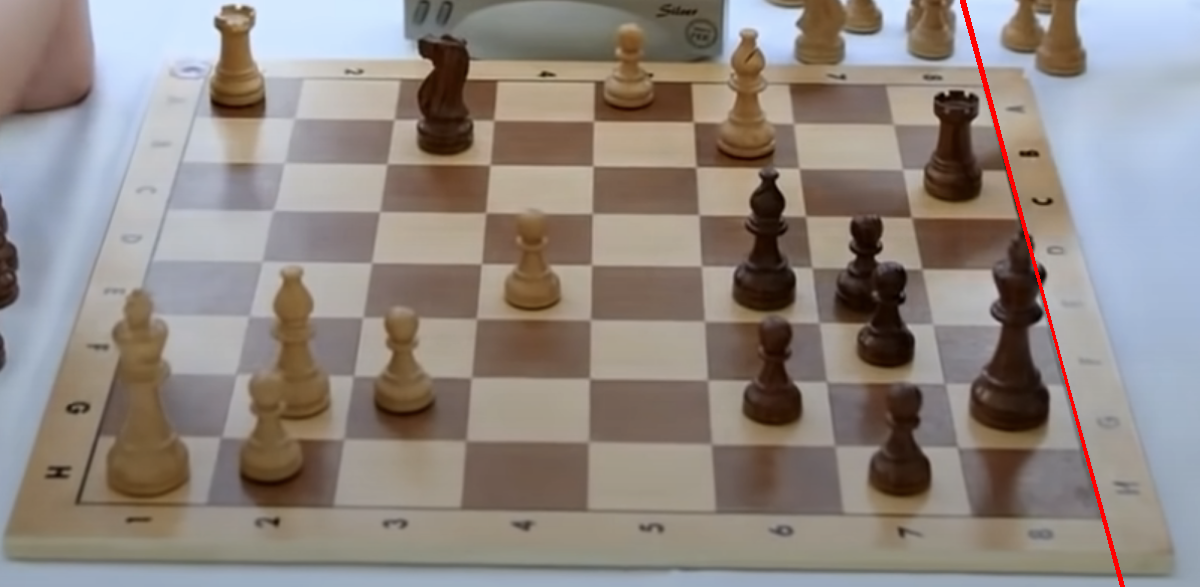

'bad'

In [9]:
single_img_2('./bad_img_2.png')
